# Metagraph and Metapath Generation

Here, we use the same syntax as [HetNetPy](https://github.com/hetio/hetnetpy/tree/e1ff1f8296b766dd5a63e5870a8a1a7d82427a80) to create a metagraph and extract metapaths from the KG.

Metagraph creation is based on [this notebook](https://github.com/dhimmel/integrate/blob/93feba1765fbcd76fd79e22f25121f5399629148/integrate.ipynb).

In [1]:
import pandas as pd
import seaborn as sns
import os.path as osp

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

%matplotlib inline

### Define and Instantiate Metagraph:

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Gene': 'G',
    'Biological Process': 'BP',
    
    # metaedges
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'participates': 'p'
}

metaedge_tuples = [
    ('Compound', 'Gene', 'upregulates', 'forward'),
    ('Compound', 'Gene', 'downregulates', 'forward'),
    ('Gene', 'Gene', 'interacts', 'forward'),
    ('Gene', 'Biological Process', 'participates', 'forward')
]

metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

In [3]:
KG_DIR = '../data/kg/'

kg = pd.read_csv(osp.join(KG_DIR, 'full_kg.tsv'), sep='\t', index_col=0)

In [4]:
kg.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates


In [5]:
seen = set()

for i, row in kg.iterrows():
    if not row['source'] in seen:
        graph.add_node(kind=row['source_node_type'], identifier=row['source'])
        seen.add(row['source'])
    if not row['target'] in seen:
        graph.add_node(kind=row['target_node_type'], identifier=row['target'])
        seen.add(row['target'])

    src_id = row['source_node_type'], row['source']
    trgt_id = row['target_node_type'], row['target']

    graph.add_edge(source_id=src_id, target_id=trgt_id, kind=row['edge_type'], direction='forward')

## Network Visualization and Stats

In [6]:
metanode_df = hetnetpy.stats.get_metanode_df(graph)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
2,Biological Process,BP,1,76,0
0,Compound,C,2,272,0
1,Gene,G,4,9421,0


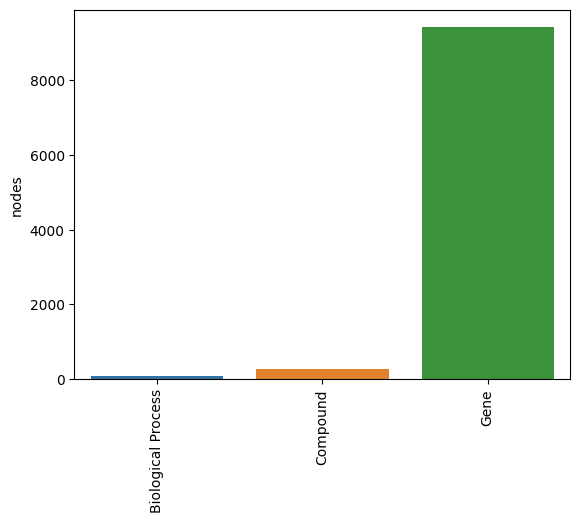

In [7]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

In [8]:
# Total number of nodes
metanode_df.nodes.sum()

9769

In [9]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
1,Compound > downregulates > Gene,Cd>G,2185,251,914
0,Compound > upregulates > Gene,Cu>G,1623,176,864
2,Gene > interacts > Gene,Gi>G,86786,5240,8578
3,Gene > participates > Biological Process,Gp>BP,6949,3640,76


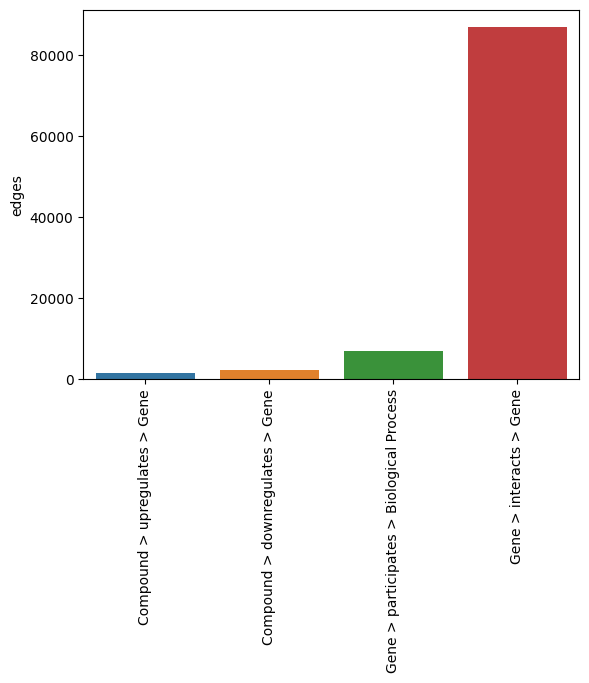

In [10]:
ax = sns.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

In [11]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
7,Biological Process < participates < Gene,Biological Process←participates←Gene,Gene > participates > Biological Process,BP<pG,GpBP,Biological Process,Gene,1
2,Compound > downregulates > Gene,Compound→downregulates→Gene,Compound > downregulates > Gene,Cd>G,CdG,Compound,Gene,0
0,Compound > upregulates > Gene,Compound→upregulates→Gene,Compound > upregulates > Gene,Cu>G,CuG,Compound,Gene,0
3,Gene < downregulates < Compound,Gene←downregulates←Compound,Compound > downregulates > Gene,G<dC,CdG,Gene,Compound,1
5,Gene < interacts < Gene,Gene←interacts←Gene,Gene > interacts > Gene,G<iG,GiG,Gene,Gene,1
1,Gene < upregulates < Compound,Gene←upregulates←Compound,Compound > upregulates > Gene,G<uC,CuG,Gene,Compound,1
4,Gene > interacts > Gene,Gene→interacts→Gene,Gene > interacts > Gene,Gi>G,GiG,Gene,Gene,0
6,Gene > participates > Biological Process,Gene→participates→Biological Process,Gene > participates > Biological Process,Gp>BP,GpBP,Gene,Biological Process,0


In [12]:
# Number of edges in the network
metaedge_df.edges.sum()

97543

## Metapath Extraction

Here, we have functions which can extract metapaths:

Extract all metapaths up to a certain length:

In [13]:
len_3_metapaths = metagraph.extract_all_metapaths(max_length=3, exclude_inverts=True)

In [14]:
len_3_metapaths

[BP<pG,
 Cd>G,
 Cu>G,
 G<iG,
 BP<pGp>BP,
 BP<pG<dC,
 BP<pG<uC,
 BP<pG<iG,
 BP<pGi>G,
 Cd>G<dC,
 Cd>G<uC,
 Cd>G<iG,
 Cd>Gi>G,
 Cu>G<uC,
 Cu>G<iG,
 Cu>Gi>G,
 Gp>BP<pG,
 G<dCd>G,
 G<dCu>G,
 G<uCu>G,
 G<iG<iG,
 G<iGi>G,
 Gi>G<iG,
 BP<pGp>BP<pG,
 BP<pG<dCd>G,
 BP<pG<dCu>G,
 BP<pG<uCd>G,
 BP<pG<uCu>G,
 BP<pG<iGp>BP,
 BP<pG<iG<dC,
 BP<pG<iG<uC,
 BP<pG<iG<iG,
 BP<pG<iGi>G,
 BP<pGi>G<dC,
 BP<pGi>G<uC,
 BP<pGi>G<iG,
 BP<pGi>Gi>G,
 Cd>Gp>BP<pG,
 Cd>G<dCd>G,
 Cd>G<dCu>G,
 Cd>G<uCd>G,
 Cd>G<uCu>G,
 Cd>G<iG<dC,
 Cd>G<iG<uC,
 Cd>G<iG<iG,
 Cd>G<iGi>G,
 Cd>Gi>G<uC,
 Cd>Gi>G<iG,
 Cd>Gi>Gi>G,
 Cu>Gp>BP<pG,
 Cu>G<dCd>G,
 Cu>G<dCu>G,
 Cu>G<uCd>G,
 Cu>G<uCu>G,
 Cu>G<iG<uC,
 Cu>G<iG<iG,
 Cu>G<iGi>G,
 Cu>Gi>G<iG,
 Cu>Gi>Gi>G,
 Gp>BP<pG<iG,
 Gp>BP<pGi>G,
 G<dCd>G<iG,
 G<dCd>Gi>G,
 G<dCu>G<iG,
 G<dCu>Gi>G,
 G<uCd>G<iG,
 G<uCd>Gi>G,
 G<uCu>G<iG,
 G<uCu>Gi>G,
 G<iG<iG<iG,
 G<iG<iGi>G,
 G<iGi>G<iG,
 Gi>G<iG<iG]

Extract metapaths from a given source node type (and, optionally, to a target node type):

In [15]:
metagraph.extract_metapaths(source='Compound', target='Biological Process')

[Cd>Gp>BP,
 Cu>Gp>BP,
 Cd>G<iGp>BP,
 Cd>Gi>Gp>BP,
 Cu>G<iGp>BP,
 Cu>Gi>Gp>BP,
 Cd>Gp>BP<pGp>BP,
 Cd>G<dCd>Gp>BP,
 Cd>G<dCu>Gp>BP,
 Cd>G<uCd>Gp>BP,
 Cd>G<uCu>Gp>BP,
 Cd>G<iG<iGp>BP,
 Cd>G<iGi>Gp>BP,
 Cd>Gi>G<iGp>BP,
 Cd>Gi>Gi>Gp>BP,
 Cu>Gp>BP<pGp>BP,
 Cu>G<dCd>Gp>BP,
 Cu>G<dCu>Gp>BP,
 Cu>G<uCd>Gp>BP,
 Cu>G<uCu>Gp>BP,
 Cu>G<iG<iGp>BP,
 Cu>G<iGi>Gp>BP,
 Cu>Gi>G<iGp>BP,
 Cu>Gi>Gi>Gp>BP]